In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from imblearn import under_sampling, over_sampling
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load Dataset

In [ ]:
df = pd.read_csv('churn.csv')
df.head(5)

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.shape

(7046, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


# Basic Data Cleansing

### Check missing values and drop the features

In [ ]:
df.isnull().sum()

customerID           9
Gender              16
SeniorCitizen       12
Partner             16
Dependents          19
Tenure              17
Contract            13
PaperlessBilling    13
PaymentMethod       11
MonthlyCharges      10
TotalCharges         0
Churn                0
dtype: int64

In [ ]:
df.dropna(axis=0, inplace=True)
df.isnull().sum()

customerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Remove duplicates

In [ ]:
print(f"Data Frame Dimension Before Duplicate Removal: {df.shape}")
df = df.drop_duplicates()
print(f"Data Frame Dimension After Duplicate Removal: {df.shape}")

Data Frame Dimension Before Duplicate Removal: (6911, 12)
Data Frame Dimension After Duplicate Removal: (6898, 12)


In [ ]:
# drop `customerID` as they have no value to analysis the model 
df.drop(['customerID'],axis=1,inplace=True)
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0.0,No,No,8.0,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


In [ ]:
# Converting churn to numeric manually due to contains class labels.
df['Churn'].replace({'Yes': 1,'No': 0},inplace=True)

In [ ]:
# Numerical column
df_num = df.select_dtypes(['int','float']).columns.drop('Churn')
df_num

Index(['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

## Handle Categorical data

In [ ]:
df1 = df
le = {}

print("-----Value for Categorical Columns-----")
for col in df1.columns:
    if not col in ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges','Churn']:
        print( "--{}--\n{}".format(col, df1[col].value_counts()) )
        le[col] = LabelEncoder()
        df1[col] = le[col].fit_transform(df1[col])
        
        print( "Transformed:\n{}\n".format(df1[col].value_counts()) )

-----Value for Categorical Columns-----
--Gender--
Male      3488
Female    3410
Name: Gender, dtype: int64
Transformed:
1    3488
0    3410
Name: Gender, dtype: int64

--Partner--
No     3573
Yes    3325
Name: Partner, dtype: int64
Transformed:
0    3573
1    3325
Name: Partner, dtype: int64

--Dependents--
No     4845
Yes    2053
Name: Dependents, dtype: int64
Transformed:
0    4845
1    2053
Name: Dependents, dtype: int64

--Contract--
Month-to-month    3803
Two year          1653
One year          1442
Name: Contract, dtype: int64
Transformed:
0    3803
2    1653
1    1442
Name: Contract, dtype: int64

--PaperlessBilling--
Yes    4088
No     2810
Name: PaperlessBilling, dtype: int64
Transformed:
1    4088
0    2810
Name: PaperlessBilling, dtype: int64

--PaymentMethod--
Electronic check             2309
Mailed check                 1581
Bank transfer (automatic)    1514
Credit card (automatic)      1494
Name: PaymentMethod, dtype: int64
Transformed:
2    2309
3    1581
0    1514
1 

In [ ]:
df2 = pd.get_dummies(data=df1, columns=['PaymentMethod'])
df2.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
1,1,0.0,0,0,34.0,1,0,56.95,1889.50,0,0,0,0,1
2,1,0.0,0,0,2.0,0,1,53.85,108.15,1,0,0,0,1
3,1,0.0,0,0,45.0,1,0,42.30,1840.75,0,1,0,0,0
4,0,0.0,0,0,2.0,0,1,70.70,151.65,1,0,0,1,0
5,0,0.0,0,0,8.0,0,1,99.65,820.50,1,0,0,1,0


## Multicollinearity study

In [ ]:
sm_df = df2.corr(method='spearman')
sm_df.style.applymap(lambda x: "background-color: red" if x>0.7 else "background-color: white")

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
Gender,1.000000,-0.001429,0.000407,0.010713,0.002317,0.001334,-0.013640,-0.011985,-0.001169,-0.006454,-0.014403,-0.000315,0.000274,0.014184
SeniorCitizen,-0.001429,1.000000,0.016208,-0.207812,0.017607,-0.143385,0.158602,0.226010,0.110123,0.150304,-0.017270,-0.023812,0.171872,-0.152622
Partner,0.000407,0.016208,1.000000,0.453964,0.387673,0.295345,-0.014474,0.108370,0.342476,-0.151734,0.110203,0.084419,-0.084224,-0.096691
Dependents,0.010713,-0.207812,0.453964,1.000000,0.166540,0.239492,-0.111434,-0.106608,0.080591,-0.163287,0.049334,0.063390,-0.148633,0.056169
Tenure,0.002317,0.017607,0.387673,0.166540,1.000000,0.673180,0.006491,0.276701,0.889130,-0.367158,0.248025,0.237738,-0.212267,-0.238907
Contract,0.001334,-0.143385,0.295345,0.239492,0.673180,1.000000,-0.178635,-0.047987,0.465969,-0.403893,0.188026,0.215091,-0.344676,-0.008973
PaperlessBilling,-0.013640,0.158602,-0.014474,-0.111434,0.006491,-0.178635,1.000000,0.348338,0.155989,0.193602,-0.018000,-0.014610,0.209832,-0.203539
MonthlyCharges,-0.011985,0.226010,0.108370,-0.106608,0.276701,-0.047987,0.348338,1.000000,0.639206,0.185441,0.046650,0.033078,0.264372,-0.375171
TotalCharges,-0.001169,0.110123,0.342476,0.080591,0.889130,0.465969,0.155989,0.639206,1.000000,-0.229718,0.210509,0.199404,-0.060347,-0.334961
Churn,-0.006454,0.150304,-0.151734,-0.163287,-0.367158,-0.403893,0.193602,0.185441,-0.229718,1.000000,-0.117962,-0.133455,0.300245,-0.090143


In [ ]:
#drop columns with high multicollinearity
df_clean_multicol = df.drop(columns=['TotalCharges'])

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_clean_multicol.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_clean_multicol.values, i)
                          for i in range(len(df_clean_multicol.columns))]
  
print(vif_data)

            feature       VIF
0            Gender  1.886466
1     SeniorCitizen  1.347524
2           Partner  2.814029
3        Dependents  1.916148
4            Tenure  6.904102
5          Contract  3.598740
6  PaperlessBilling  2.835976
7     PaymentMethod  2.325398
8    MonthlyCharges  6.428449
9             Churn  1.731569


## Split data

### Handling balance with SMOTE

In [ ]:
over_smote = over_sampling.SMOTE

x1 = df_clean_multicol.drop(['Churn'],axis=1)
y1 = df_clean_multicol['Churn']

x_over_smote, y_over_smote = over_sampling.SMOTE().fit_resample(x1, y1)

print(f'''Shape of X before SMOTE: {x1.shape}
Shape of X after SMOTE: {x_over_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_over_smote.value_counts(normalize=True) * 100

Shape of X before SMOTE: (6898, 9)
Shape of X after SMOTE: (10146, 9)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Churn, dtype: float64

# Modeling

## Random Forest

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_over_smote, y_over_smote, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)
preds_balance = model.predict(x_test)

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

# note: we use recall
rf_clf_gridcv = GridSearchCV(model, parameters, cv=5, scoring='recall')
rf_clf_gridcv.fit(x_train, y_train)

CPU times: user 12.5 s, sys: 39.5 ms, total: 12.6 s
Wall time: 12.6 s


In [ ]:
# the results
cv_result = pd.DataFrame(rf_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
5,"{'max_depth': 2, 'n_estimators': 10}",0.906099,1
14,"{'max_depth': 3, 'n_estimators': 50}",0.877585,2
15,"{'max_depth': 4, 'n_estimators': 10}",0.876846,3
11,"{'max_depth': 3, 'n_estimators': 20}",0.875863,4
19,"{'max_depth': 4, 'n_estimators': 50}",0.874879,5
9,"{'max_depth': 2, 'n_estimators': 50}",0.874143,6
13,"{'max_depth': 3, 'n_estimators': 40}",0.873648,7
16,"{'max_depth': 4, 'n_estimators': 20}",0.873403,8
23,"{'max_depth': 5, 'n_estimators': 40}",0.872665,9
6,"{'max_depth': 2, 'n_estimators': 20}",0.872177,10


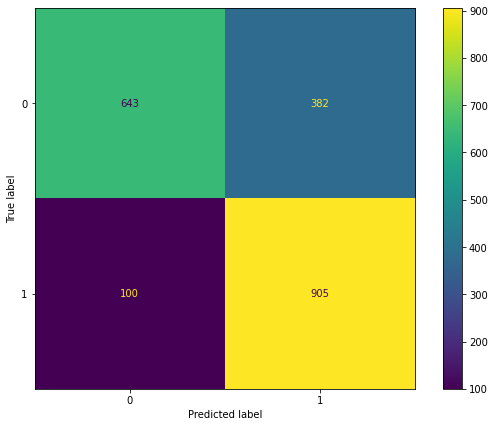

In [ ]:
#the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = rf_clf_gridcv.best_estimator_.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=rf_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_clf_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

True Negatif `Churn` : 643

False Negatif `Churn` : 382 

False Positif `Churn` : 100 

True Positif `Churn` : 905 

In [ ]:
# classification report

y_pred = rf_clf_gridcv.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1025
           1       0.70      0.90      0.79      1005

    accuracy                           0.76      2030
   macro avg       0.78      0.76      0.76      2030
weighted avg       0.79      0.76      0.76      2030



**Conclusion**

Best optimum results obtained after *balance date* with SMOTE and hyperparamter `Random Forest Classifier`. From dataset, `Random Forest Classifier` managed to detect churn accuracy of 76%

*Precision* 0.70 that the model is able to predict data from Churn data for 1005 customers who are predicted to be positive model(70%)

*Recall* 0.90 that the model is able to predict data from Churn data for 1005 customers who are predicted to be positive model(90%)